<a href="https://colab.research.google.com/github/Vaishnavi24-tech/Landmark-Detection/blob/main/landmarkdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from json import encoder
import numpy as np
import pandas as pd
import keras
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from keras.applications import VGG19
from keras.layers  import Dense,Flatten,BatchNormalization,Dropout
from keras import Sequential,optimizers

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/train.csv/train.csv")
base_path ="/content/drive/MyDrive/images"
df

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7
...,...,...
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092


In [ ]:
samples = 20000
df = df.loc[df["id"].str.startswith('00', na=False), :]
num_classes = len(df["landmark_id"].unique())
num_data = len(df)

In [ ]:
num_classes

5346

In [ ]:
num_data

6120

In [ ]:
data = pd.DataFrame(df["landmark_id"].value_counts())

data.reset_index(inplace=True)
data.head()

,landmark_id,count
0,138982,31
1,83144,14
2,126637,7
3,194914,7
4,109169,6


In [ ]:
data.tail()

,landmark_id,count
5341,71434,1
5342,71336,1
5343,71228,1
5344,71145,1
5345,202981,1


In [ ]:
data.columns=['landmark_id','count']

In [ ]:
data['count'].describe()

,count
count,5346.000000
mean,1.144781
std,0.641260
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,31.000000


(array([0.000e+00, 4.781e+03, 0.000e+00, 4.520e+02, 0.000e+00, 7.500e+01,
        2.200e+01, 0.000e+00, 9.000e+00, 0.000e+00, 3.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

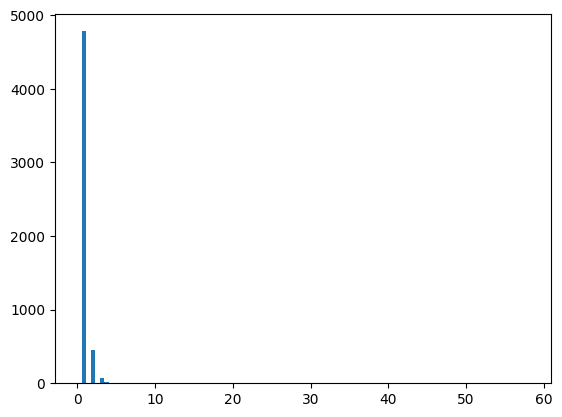

In [ ]:
plt.hist(data['count'], 100, range = (0,58), label = 'test')

In [ ]:
data['count'].between(0,5).sum()

5339

In [ ]:
data['count'].between(5,10).sum()

14

(array([2., 1., 1., ..., 1., 1., 2.]),
 array([2.70000e+01, 6.00000e+01, 1.24000e+02, ..., 2.02950e+05,
        2.02972e+05, 2.02981e+05]),
 <BarContainer object of 5345 artists>)

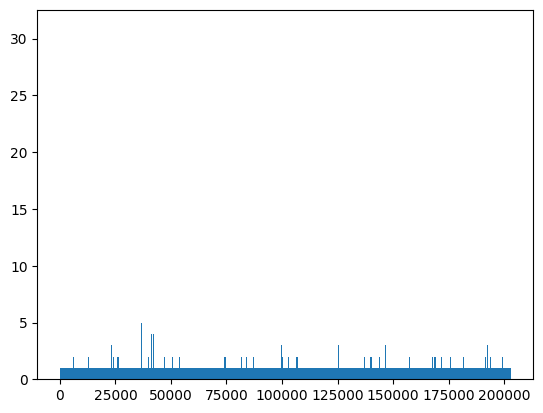

In [ ]:
plt.hist(df["landmark_id"],bins=df["landmark_id"].unique())

In [ ]:
#Trainig of model
lencoder = LabelEncoder()
lencoder.fit(df['landmark_id'].unique())

LabelEncoder()

In [ ]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [ ]:
def encode_label(lb1):
    return lencoder.transform(lb1)

In [ ]:
def decode_label(lb1):
    return lencoder.inverse_tranform(lb1)

In [ ]:
def get_image_from_number(num,dataframe):
    fname = dataframe.loc[num, 'id']  # Access 'id' column using loc
    label = dataframe.loc[num, 'landmark_id']  # Access 'landmark_id' column using loc
    fname = fname + '.jpg'
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im =  cv2.imread(os.path.join(base_path, path))
    return im, label

4 Sample images from random classes


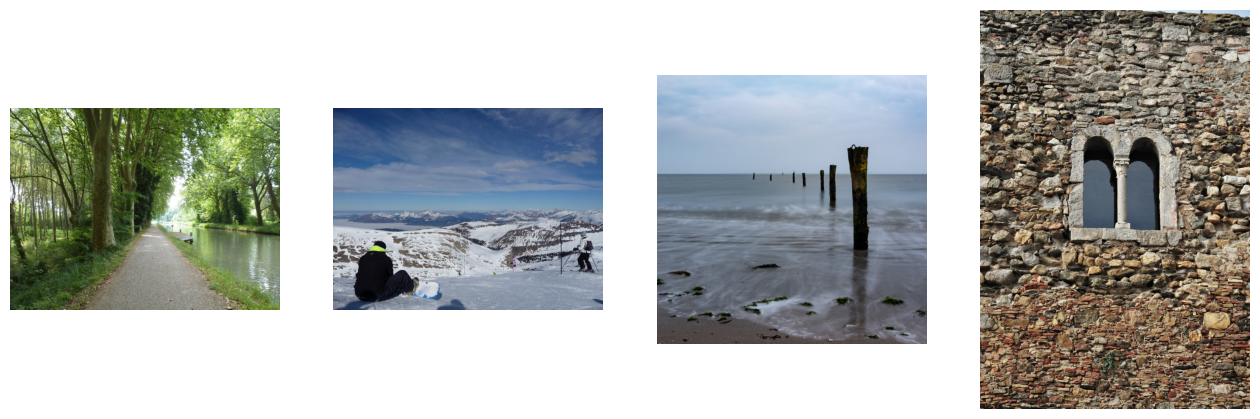

In [ ]:
print("4 Sample images from random classes")
fig = plt.figure(figsize=(16, 16))
for i in range(1, 5):
    a = random.choices(os.listdir(base_path), k=3)
    folder = base_path + '/' + a[0] + '/' + a[1] + '/' + a[2]
    random_img = random.choices(os.listdir(folder))
    img = np.array(Image.open(folder + '/' + random_img[0]))
    fig.add_subplot(1,4,i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
from keras.applications import VGG19
from keras.layers import *
from keras import Sequential
tf.compat.v1.disable_eager_execution()

In [ ]:
#parameters
learning_rate   = 0.000
decay_speed     = 1e-6
momentum        = 0.09
loss_function   = "sparse_categorical_crossentropy"

In [ ]:
source_model = VGG19(weights=None)
#new_layer = Dense(num_classes, activation=activations.softmax, name='prediction')
drop_layer = Dropout(0.5)
drop_layer2 = Dropout(0.5)

In [ ]:
model = Sequential()
for layer in source_model.layers[:-1]: # go through until last layer
    if layer == source_model.layers[-25]:
        model.add(BatchNormalization())
    model.add(layer)


In [ ]:
if layer == source_model.layers[-3]:
   model.add(drop_layer)
   model.add(drop_layer2)
model.add(Dense(num_classes, activation="softmax"))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,8

 Total params: 161,472,814 (615.97 MB)

 Trainable params: 161,472,808 (615.97 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
optim1 = keras.optimizers.RMSprop(learning_rate = 0.0001, momentum = 0.09)
optim2 = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(optimizer=optim1,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [ ]:
from tensorflow import keras
from keras.optimizers import SGD # Import SGD from keras.optimizers
sgd = SGD(learning_rate=learning_rate, decay=decay_speed, momentum=momentum, nesterov=True)
rms = keras.optimizers.RMSprop(learning_rate=learning_rate, momentum=momentum)
model.compile(optimizer=rms,
              loss=loss_function,
              metrics=["accuracy"])
print("Model compiled! n")

Model compiled! n


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
#Function used to process the data, fitted into a data generator.
def get_image_from_number(num, df):
    fname, label = df.iloc[num,:]
    fname = fname + ".jpg"
    f1 = fname[0]
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1,f2,f3,fname)
    im = cv2.imread(os.path.join(base_path,path))
    return im, label

In [ ]:
def image_reshape(im, target_size):
# Check if image has valid dimensions before resizing
    if im.shape[0] > 0 and im.shape[1] > 0:
       return cv2.resize(im, target_size)
    else:
        print(f"Invalid image dimensions: {im.shape}")
        return None  # Or handle differently, e.g., return a placeholder image

In [ ]:
def get_batch(dataframe, start, batch_size):
    image_array = []
    label_array = []
    end = min(start + batch_size, len(dataframe))

    for idx in range(start, end):
        n = dataframe.index[idx]
        im, label = get_image_from_number(n, dataframe)
        if im is not None and im.size != 0:
            try:
                im = image_reshape(im, (224, 224)) / 255.0
                image_array.append(im)
                label_array.append(label)
            except cv2.error as e:
                print(f"Error resizing image at index {idx}: {e}")  # Print specific error
        else:
            print(f"Skipping invalid image at index {idx}")

    X_train = np.array(image_array)
    y_train = np.array(label_array)

    return X_train, y_train


def image_reshape(im, target_size):
    # Check if image has valid dimensions before resizing
    if im.shape[0] > 0 and im.shape[1] > 0:
        return cv2.resize(im, target_size)
    else:
        print(f"Invalid image dimensions: {im.shape}")
        return None  # Or handle differently, e.g., return a placeholder image

In [ ]:
batch_size = 16
epoch_shuffle = True
weight_classes = True
epochs = 1

In [ ]:
# Split train data up into 80% and 20% validation
train, validate = np.split(df.sample(frac=1), [int(.8*len(df))])
print("Training on:", len(train), "samples")
print("Validation on:", len(validate), "samples")

Training on: 4896 samples
Validation on: 1224 samples


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
for e in range(epochs):
    print("Epoch: ", str(e+1) + "/" + str(epochs))
    if epoch_shuffle:
        train = train.sample(frac = 1)
    for it in range(int(np.ceil(len(train)/batch_size))):
        X_train, y_train = get_batch(train, it*batch_size, batch_size)
        model.train_on_batch(X_train, y_train)
model.save("Model.h5")

Epoch:  1/1


IndexError: single positional indexer is out-of-bounds

In [ ]:
### Test on the training set
batch_size = 16
errors = 0
good_preds = []
bad_preds = []
for it in range(int(np.ceil(len(validate)/batch_size))):
    X_train, y_train = get_batch(validate, it*batch_size, batch_size)
    result = model.predict(X_train)
    cla = np.argmax(result, axis=1)
    for idx, res in enumerate(result):
        print("Class:", cla[idx], "- Confidence:", np.round(res[cla[idx]],2), "- GT:", y_train[idx])
        if cla[idx] != y_train[idx]:
            errors = errors + 1
            bad_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
        else:
            good_preds.append([batch_size*it + idx, cla[idx], res[cla[idx]]])
print("Errors: ", errors, "Acc:", np.round(100*(len(validate)-errors)/len(validate),2))
#Good predictions
good_preds = np.array(good_preds)
good_preds = np.array(sorted(good_preds, key = lambda x: x[2], reverse=True))

In [ ]:
fig=plt.figure(figsize=(16, 16))
for i in range(1,6):
    n = int(good_preds[i,0])
    img, lbl = get_image_from_number(n, validate)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, 5, i)
    plt.imshow(img)
    lbl2 = np.array(int(good_preds[i,1])).reshape(1,1)
    sample_cnt = list(df.landmark_id).count(lbl)
    plt.title("Label: " + str(lbl) + "nClassified as: " + str(decode_label(lbl2)) + "nSamples in class " + str(lbl) + ": " + str(sample_cnt))
    plt.axis('off')
plt.show()